# GABA-A Receptor α2-Selective Compound Training Set Construction

## Final Project: In Silico Identification of Novel α2-selective Positive Allosteric Modulators (PAMs) for GABA-A Receptors in Anxiety Treatment

**Student:** Pablo Rodríguez López.    
**Course**: Computational Structural Biology for Lead Discovery.   
**University**: Polytechnic University of Madrid.  
**Date:** January 2026.   
**Objective:** This notebook constructs a training dataset for the α2-selective GABA-A positive allosteric modulator discovery project.  

---

**Workflow:**
1. Load and validate ChEMBL data (α1β3γ2 and α2β3γ2 subtypes)
2. Canonicalize SMILES strings
3. Deduplicate by keeping lowest Ki values
4. Merge datasets and calculate selectivity ratios
5. Filter for active binders and generate quality control visualizations
6. Export training set for virtual screening

**Key Parameters:**
- Activity threshold: Ki < 100 nM (0.1 µM) = "active"
- Selectivity threshold: log2(Ki_α1/Ki_α2) > 2 = 4-fold α2 preference
- β/γ composition: Consistent β3γ2 across both α1 and α2 to isolate α subunit effects

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import warnings
warnings.filterwarnings('ignore')

print("All libraries successfully loaded")

All libraries successfully loaded


##  1. Data Importation and Preparation

### 1.1 Load the Data

ChEMBL bioactivity data for two GABA-A receptor subtypes:
- **α1β3γ2:** The "sedative" subtype (responsible for sleep-promoting effects).
  - **Source**: Bioactivity data for target CHEMBL2094121 (GABA-A receptor; alpha-1/beta-3/gamma-2) - Ki
- **α2β3γ2:** The "anxiolytic" subtype (responsible for anxiety relief without sedation)
  - **Source**: Bioactivity data for target CHEMBL2094130 (GABA-A receptor; alpha-2/beta-3/gamma-2) - Ki

By using the same β3γ2 background, we isolate the contribution of the α subunit to selectivity.

In [23]:
# Load ChEMBL bioactivity data
print("Loading ChEMBL data...\n")

alpha1 = pd.read_csv("alpha1_beta3_gamma2_ki_values.csv", sep=';')
alpha2 = pd.read_csv("alpha2_beta3_gamma2_ki_values.csv", sep=';')

print(f"Alpha1 (α1β3γ2) raw data: {len(alpha1)} entries")
print(f"Alpha2 (α2β3γ2) raw data: {len(alpha2)} entries")
print(f"\nColumns in dataset alpha1: {alpha1.columns.tolist()} ...")
print(f"Columns in dataset alpha2: {alpha2.columns.tolist()} ...")

Loading ChEMBL data...

Alpha1 (α1β3γ2) raw data: 887 entries
Alpha2 (α2β3γ2) raw data: 749 entries

Columns in dataset alpha1: ['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties', 'Action T

Key columns:
* 'Molecule ChEMBL ID'
* 'Smiles'
* 'Standard Value'
* 'Standard Unit'

### 1.2 Check Units and Ki Ranges

Ki values must be in consistent units (nanoMolar, nM). Different units or extreme outliers can indicate data quality issues.

UNITS CHECK

Alpha1 units: ['nM' nan]
Alpha2 units: ['nM' nan]

KI VALUE DISTRIBUTIONS (before filtering)


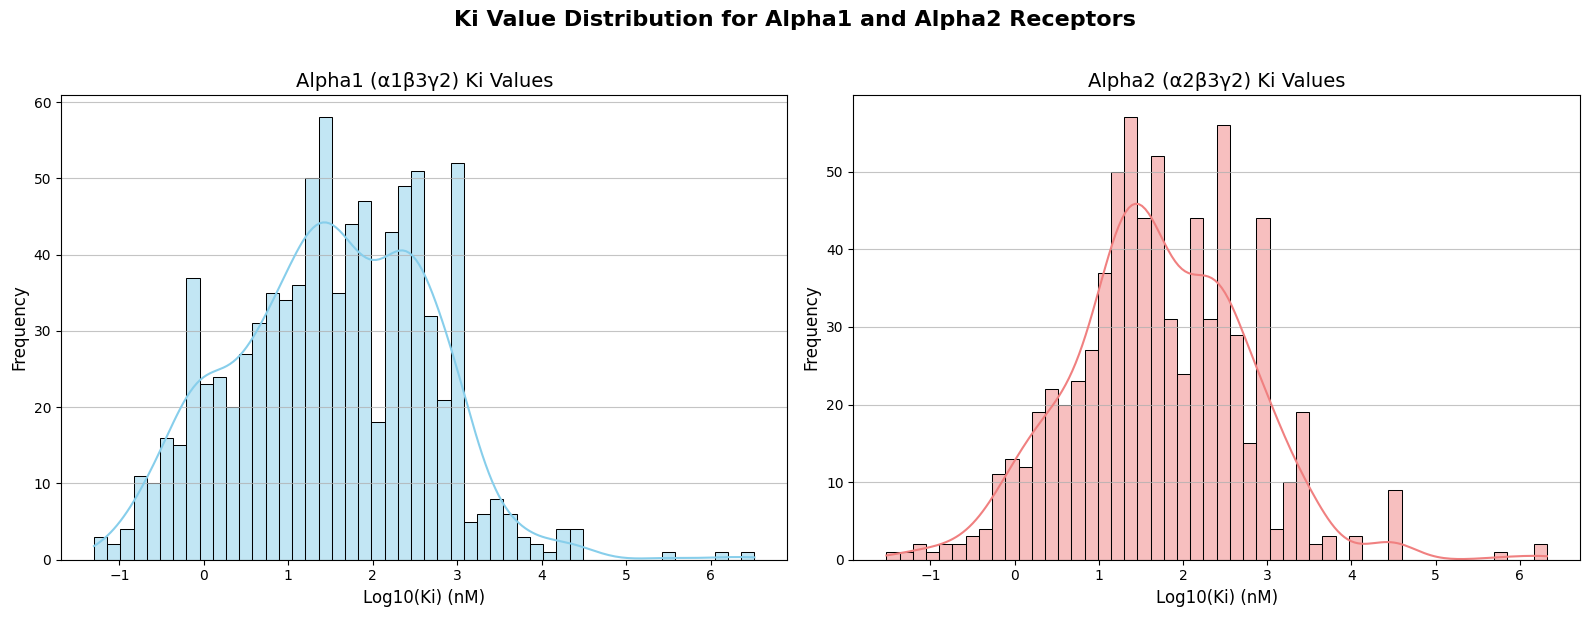

Saved: 00_Ki_distribution_histograms.png


In [24]:
# Check units in both datasets
print("="*70)
print("UNITS CHECK")
print("="*70)
print(f"\nAlpha1 units: {alpha1['Standard Units'].unique()}")
print(f"Alpha2 units: {alpha2['Standard Units'].unique()}")

# Check Ki value ranges with histograms
print(f"\n" + "="*70)
print("KI VALUE DISTRIBUTIONS (before filtering)")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Ki Value Distribution for Alpha1 and Alpha2 Receptors', fontsize=16, weight='bold', y=1.02)

# Alpha1 Ki distribution
sns.histplot(np.log10(alpha1['Standard Value']), bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Alpha1 (α1β3γ2) Ki Values', fontsize=14)
axes[0].set_xlabel('Log10(Ki) (nM)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].grid(axis='y', alpha=0.75)

# Alpha2 Ki distribution
sns.histplot(np.log10(alpha2['Standard Value']), bins=50, kde=True, ax=axes[1], color='lightcoral')
axes[1].set_title('Alpha2 (α2β3γ2) Ki Values', fontsize=14)
axes[1].set_xlabel('Log10(Ki) (nM)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.savefig('00_Ki_distribution_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 00_Ki_distribution_histograms.png")


Both distributions have similar profiles. Extremely large Ki values correspond to molecules that are just not binding to the receptor.

### 1.3 Remove Rows with Missing Data

ChEMBL databases can have incomplete entries. We remove rows with:
- Missing Ki values ("Standard Value" column)
- Missing or inconsistent units ("Standard Units" column)

In [25]:
# Remove rows with missing Ki values
alpha1 = alpha1.dropna(subset=['Standard Value'])
alpha2 = alpha2.dropna(subset=['Standard Value'])

# Remove rows with missing units
alpha1 = alpha1.dropna(subset=['Standard Units'])
alpha2 = alpha2.dropna(subset=['Standard Units'])

# Remove rows with missing SMILES
alpha1 = alpha1.dropna(subset=['Smiles'])
alpha2 = alpha2.dropna(subset=['Smiles'])

print("="*70)
print("DATA AFTER REMOVING MISSING VALUES")
print("="*70)
print(f"Alpha1: {len(alpha1)} entries")
print(f"Alpha2: {len(alpha2)} entries")

DATA AFTER REMOVING MISSING VALUES
Alpha1: 870 entries
Alpha2: 730 entries


## 2. Canonical SMILES Normalization

### 2.1 Define Canonicalization Function

SMILES strings represent the same molecule in many ways (e.g., different atom ordering). Canonicalization converts them to a unique representation using RDKit, enabling accurate compound matching across datasets.

In [26]:
def canonicalize_smiles(smiles):
    """
    Convert a SMILES string to its canonical form using RDKit.

    Parameters:
    -----------
    smiles : str
        SMILES string to canonicalize

    Returns:
    --------
    str or None
        Canonical SMILES, or None if parsing fails
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        # Convert to canonical SMILES
        canonical = Chem.MolToSmiles(mol, canonical=True)
        return canonical
    except:
        return None

print("Canonicalization function defined")

Canonicalization function defined


### 2.2 Canonicalize SMILES in Parallel

Using parallel processing (joblib) to speed up canonicalization of thousands of compounds.

In [27]:
print("\nCanonicalizing SMILES...\n")

# Alpha1 canonicalization
print("Processing Alpha1 dataset...")
alpha1['canonical_smiles'] = alpha1['Smiles'].apply(canonicalize_smiles)

# Alpha2 canonicalization
print("Processing Alpha2 dataset...")
alpha2['canonical_smiles'] = alpha2['Smiles'].apply(canonicalize_smiles)

# Remove failed canonicalizations
alpha1_clean = alpha1[alpha1['canonical_smiles'].notna()].copy()
alpha2_clean = alpha2[alpha2['canonical_smiles'].notna()].copy()

print(f"\n✓ Canonicalization complete:")
print(f"  Alpha1: {len(alpha1_clean)}/{len(alpha1)} valid ({len(alpha1)-len(alpha1_clean)} failed)")
print(f"  Alpha2: {len(alpha2_clean)}/{len(alpha2)} valid ({len(alpha2)-len(alpha2_clean)} failed)")


Canonicalizing SMILES...

Processing Alpha1 dataset...
Processing Alpha2 dataset...

✓ Canonicalization complete:
  Alpha1: 870/870 valid (0 failed)
  Alpha2: 730/730 valid (0 failed)


## 3. Handle Duplicates

Multiple entries can exist for the same compound (from different assays or publications). We keep the entry with the **lowest Ki value** (highest affinity), following a conservative/optimistic approach: if a compound showed good binding in one assay, we trust that measurement.

In [28]:
print("="*70)
print("DUPLICATE HANDLING")
print("="*70)

# Identify duplicates BEFORE deduplication
alpha1_duplicates = alpha1_clean[alpha1_clean.duplicated(subset='canonical_smiles', keep=False)]
alpha2_duplicates = alpha2_clean[alpha2_clean.duplicated(subset='canonical_smiles', keep=False)]

print(f"\nAlpha1:")
print(f"  Total entries with duplicates: {len(alpha1_duplicates)}")
print(f"  Unique compounds with duplicates: {alpha1_duplicates['canonical_smiles'].nunique()}")

print(f"\nAlpha2:")
print(f"  Total entries with duplicates: {len(alpha2_duplicates)}")
print(f"  Unique compounds with duplicates: {alpha2_duplicates['canonical_smiles'].nunique()}")

# Keep the entry with LOWEST Ki (best binding) for each compound
# sort_values() puts lowest Ki first, groupby().first() keeps it
alpha1_dedup = alpha1_clean.sort_values('Standard Value').groupby('canonical_smiles').first().reset_index()
alpha2_dedup = alpha2_clean.sort_values('Standard Value').groupby('canonical_smiles').first().reset_index()

print(f"\nAfter deduplication (keeping lowest Ki):")
print(f"  Alpha1: {len(alpha1_dedup)} unique compounds")
print(f"  Alpha2: {len(alpha2_dedup)} unique compounds")

DUPLICATE HANDLING

Alpha1:
  Total entries with duplicates: 349
  Unique compounds with duplicates: 146

Alpha2:
  Total entries with duplicates: 275
  Unique compounds with duplicates: 110

After deduplication (keeping lowest Ki):
  Alpha1: 667 unique compounds
  Alpha2: 565 unique compounds


## 4. Merge Datasets on Canonical SMILES

Only compounds tested on BOTH α1β3γ2 and α2β3γ2 are retained, ensuring we can calculate meaningful selectivity ratios.

In [29]:
print("\nMerging datasets on canonical SMILES...\n")

# Merge on canonical_smiles (inner join = only compounds in both datasets)
merged = pd.merge(
    alpha1_dedup[['canonical_smiles', 'Standard Value', 'Molecule ChEMBL ID']],
    alpha2_dedup[['canonical_smiles', 'Standard Value', 'Molecule ChEMBL ID']],
    on='canonical_smiles',
    suffixes=('_alpha1', '_alpha2'),
    how='inner'
)

# Rename Ki columns for clarity
merged.rename(columns={
    'Standard Value_alpha1': 'Ki_alpha1',
    'Standard Value_alpha2': 'Ki_alpha2'
}, inplace=True)

# Create consensus ChEMBL ID
def create_consensus_id(row):
    """
    Create a consensus ChEMBL ID from alpha1 and alpha2 columns.
    If both are the same, use one. If different, concatenate both.
    """
    id_alpha1 = row['Molecule ChEMBL ID_alpha1']
    id_alpha2 = row['Molecule ChEMBL ID_alpha2']

    if id_alpha1 == id_alpha2:
        return id_alpha1
    else:
        return f"{id_alpha1}, {id_alpha2}"

merged['ChEMBL_ID'] = merged.apply(create_consensus_id, axis=1)

# Remove the separate alpha1 and alpha2 ID columns
merged.drop(columns=['Molecule ChEMBL ID_alpha1', 'Molecule ChEMBL ID_alpha2'], inplace=True)

# Check how many compounds have matching vs different IDs
matching_ids = (merged['ChEMBL_ID'].str.contains(',') == False).sum()
different_ids = merged['ChEMBL_ID'].str.contains(',').sum()

print(f"✓ Merged dataset: {len(merged)} compounds with Ki values for both subtypes")
print(f"  - Same ChEMBL ID in both datasets: {matching_ids}")
print(f"  - Different ChEMBL IDs (concatenated): {different_ids}")



Merging datasets on canonical SMILES...

✓ Merged dataset: 502 compounds with Ki values for both subtypes
  - Same ChEMBL ID in both datasets: 502
  - Different ChEMBL IDs (concatenated): 0


## 5. Calculate Log2 Selectivity Ratio

### Rationale: Why Log2?

**Formula:** log₂(Ki_α1 / Ki_α2)

**Interpretation:**
- **Positive log₂ ratio** → Ki_α1 > Ki_α2 → Binds better to α2 → **α2-selective**
- **Negative log₂ ratio** → Ki_α1 < Ki_α2 → Binds better to α1 → **α1-selective**
- **Zero log₂ ratio** → Ki_α1 ≈ Ki_α2 → Similar binding → **Non-selective**

**Why log₂ instead of linear ratio?**
1. **Symmetry:** log₂(10) = 3.32 (10-fold α2 preference) and log₂(0.1) = -3.32 (10-fold α1 preference) are equally distant from zero
2. **Interpretability:** log₂(2) = 1 corresponds to 2-fold selectivity, a standard medicinal chemistry threshold
3. **Normalization:** Handles both very potent and very weak binders on a comparable scale

**Cutoffs:**
- log₂ > 2: At least 4-fold α2 preference
- log₂ < -2: At least 4-fold α1 preference
- -2 ≤ log₂ ≤ 2: Non-selective

In [30]:
# Calculate log2 selectivity ratio
merged['log2_ratio'] = np.log2(merged['Ki_alpha1'] / merged['Ki_alpha2'])

print(" ---> Log2 selectivity ratio calculated")
print(f"\nLog2 ratio statistics\n:")
print(f"  Mean: {merged['log2_ratio'].mean():.2f}")
print(f"  Median: {merged['log2_ratio'].median():.2f}")
print(f"  Min (most α1-selective): {merged['log2_ratio'].min():.2f}")
print(f"  Max (most α2-selective): {merged['log2_ratio'].max():.2f}")
print(f"  Std Dev: {merged['log2_ratio'].std():.2f}")

 ---> Log2 selectivity ratio calculated

Log2 ratio statistics
:
  Mean: -0.19
  Median: 0.00
  Min (most α1-selective): -15.61
  Max (most α2-selective): 5.00
  Std Dev: 1.70


## 6. Plot Histogram of Log2 Selectivity Ratios

Visual distribution of selectivity across the entire dataset. This serves as a quality control check:
- Should see bell-shaped distribution centered near zero (most compounds non-selective)
- Tails on both sides (α1- and α2-selective compounds)
- If heavily skewed, may indicate experimental bias or data quality issues

Generating histogram...



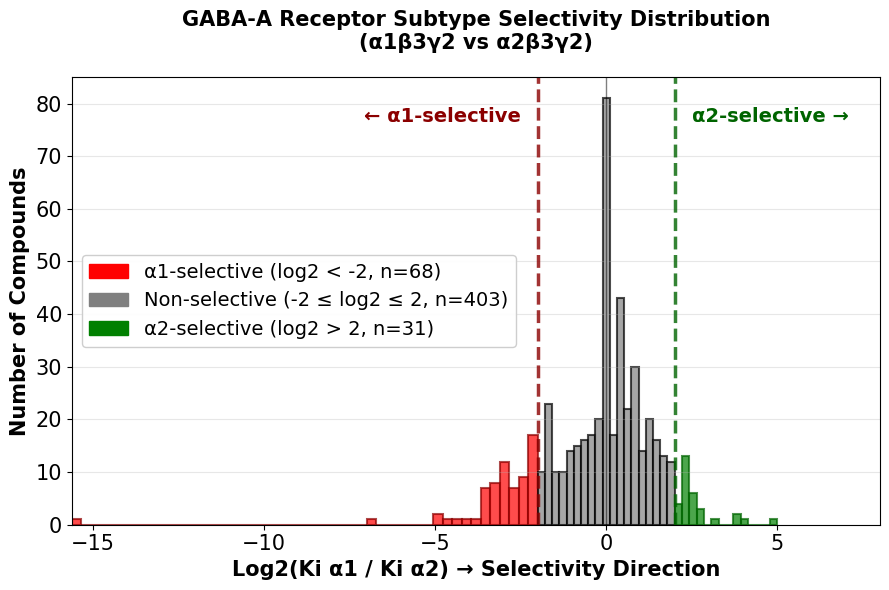

Saved: 01_selectivity_histogram.png


In [31]:
print("Generating histogram...\n")

fig, ax = plt.subplots(figsize=(9, 6))

# Separate data by selectivity category (±1 thresholds)
alpha1_selective = merged[merged['log2_ratio'] < -2]['log2_ratio']
non_selective = merged[(merged['log2_ratio'] >= -2) & (merged['log2_ratio'] <= 2)]['log2_ratio']
alpha2_selective = merged[merged['log2_ratio'] > 2]['log2_ratio']

# Create separate bins for each region to avoid overlap at thresholds
bins_alpha1 = np.linspace(merged['log2_ratio'].min(), -2, 50)
bins_non_selective = np.linspace(-2, 2, 20)
bins_alpha2 = np.linspace(2, merged['log2_ratio'].max(), 15)

# Plot histograms with separate binning for each region
ax.hist(alpha1_selective, bins=bins_alpha1, color='red', alpha=0.7,
        edgecolor='darkred', linewidth=1.5)
ax.hist(non_selective, bins=bins_non_selective, color='gray', alpha=0.7,
        edgecolor='black', linewidth=1.5)
ax.hist(alpha2_selective, bins=bins_alpha2, color='green', alpha=0.7,
        edgecolor='darkgreen', linewidth=1.5)

# Add vertical lines at selectivity cutoffs
ax.axvline(-2, color='darkred', linestyle='--', linewidth=2.5, alpha=0.8)
ax.axvline(2, color='darkgreen', linestyle='--', linewidth=2.5, alpha=0.8)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Labels and formatting
ax.set_xlabel('Log2(Ki α1 / Ki α2) → Selectivity Direction', fontsize=15, weight='bold')
ax.set_ylabel('Number of Compounds', fontsize=15, weight='bold')
ax.set_title('GABA-A Receptor Subtype Selectivity Distribution\n(α1β3γ2 vs α2β3γ2)',
             fontsize=15, weight='bold', pad=20)
ax.set_xlim(merged['log2_ratio'].min(), 8)
# x-axis and y-axis ticks formatting
ax.tick_params(axis='both', which='major', labelsize=15)

# Add text annotations
ax.text(-2.5, ax.get_ylim()[1]*0.9, '← α1-selective', fontsize=14, ha='right', color='darkred', weight='bold')
ax.text(2.5, ax.get_ylim()[1]*0.9, 'α2-selective →', fontsize=14, ha='left', color='darkgreen', weight='bold')

# Create custom legend patches (like your COX example)
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label=f'α1-selective (log2 < -2, n={len(alpha1_selective)})')
gray_patch = mpatches.Patch(color='gray', label=f'Non-selective (-2 ≤ log2 ≤ 2, n={len(non_selective)})')
green_patch = mpatches.Patch(color='green', label=f'α2-selective (log2 > 2, n={len(alpha2_selective)})')
ax.legend(handles=[red_patch, gray_patch, green_patch], fontsize=14, loc='center left', framealpha=0.95)

ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('01_selectivity_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 01_selectivity_histogram.png")

## 7. Fine Labeling: Activity + Selectivity Classification

Not all "selective" compounds are useful for drug discovery. We classify compounds based on two orthogonal properties:

**Activity:** Does the compound actually bind? (Ki < 0.1 µM = yes)
- Ki < 100 nM: **Active** (binds with reasonable affinity)
- 100 < Ki < 10,000 nM: **Weak-binder** (borderline, might be optimizable)
- Ki > 10,000 nM: **Non-binding** (no meaningful interaction)

**Selectivity:** Does it prefer one subtype? (log2 ratio)
- log2 > 2: **α2-selective** (at least 4-fold)
- log2 < -2: **α1-selective** (at least 4-fold)
- -2 ≤ log2 ≤ 2: **Pan-selective** (non-selective, binds both)

**Refined labels combine both:**
- **α2-selective:** Active + prefers α2
- **Pan-selective:** Active + no selectivity
- **α1-selective:** Active + prefers α1
- **Weak-binder:** Marginal binding
- **Non-binding:** No binding (false selectivity, filtered out)

In [32]:
print("\n" + "="*70)
print("ACTIVITY & SELECTIVITY CLASSIFICATION")
print("="*70)

# Define classification function
def classify_compound(row):
    """
    Classify compound based on activity (Ki) and selectivity (log2 ratio).

    Activity thresholds (based on best Ki):
    - < 100 nM: Active (drug-like binding)
    - 100-10,000 nM: Weak binder (borderline)
    - > 10,000 nM: Non-binding (no interaction)

    Selectivity thresholds (log2 ratio):
    - > 2: α2-selective (2-fold preference)
    - < -2: α1-selective (2-fold preference)
    - -2 to 2: Pan-selective (non-selective)
    """
    ki_a1 = row['Ki_alpha1']
    ki_a2 = row['Ki_alpha2']
    log2 = row['log2_ratio']

    # Check activity first (both Ki values must be considered)
    if ki_a1 > 10000 and ki_a2 > 10000:
        # Non-binder: weak binding to both subtypes
        return 'non-binding'
    elif min(ki_a1, ki_a2) >= 100:
        # Weak binder: marginal affinity
        return 'weak-binder'
    else:
        # Active binder: good affinity to at least one subtype
        if log2 > 2:
            return 'alpha2-selective'
        elif log2 < -2:
            return 'alpha1-selective'
        else:
            return 'pan-selective'

# Apply classification
merged['refined_label'] = merged.apply(classify_compound, axis=1)

# Print distribution
print(f"\nRefined label distribution:")
for label in ['alpha2-selective', 'pan-selective', 'alpha1-selective', 'weak-binder', 'non-binding']:
    count = (merged['refined_label'] == label).sum()
    percentage = (count / len(merged)) * 100
    print(f"  {label:20s}: {count:4d} ({percentage:5.1f}%)")

print(f"\nTotal compounds: {len(merged)}")


ACTIVITY & SELECTIVITY CLASSIFICATION

Refined label distribution:
  alpha2-selective    :   22 (  4.4%)
  pan-selective       :  245 ( 48.8%)
  alpha1-selective    :   59 ( 11.8%)
  weak-binder         :  170 ( 33.9%)
  non-binding         :    6 (  1.2%)

Total compounds: 502


A total of 97 alpha2-selective compounds were found. A total success!! That would be enough to start our screening, potentially leading to  putatively novel alpha2-selective P.A.M.s for anxiety treatment.

## 8. Scatter Plot: Log2 Ratio vs pKi (Activity vs Selectivity)

2D visualization showing the relationship between selectivity (X-axis) and binding affinity at α2 (Y-axis).

**The ideal region:** Top-right quadrant (log₂ > 1, pKi > 6)
- High selectivity for α2
- Good binding affinity (pKi > 6 ≈ 1 µM or better)
- These are the compounds prioritized for pharmacophore/LBVS


Generating 2D selectivity-activity plot...



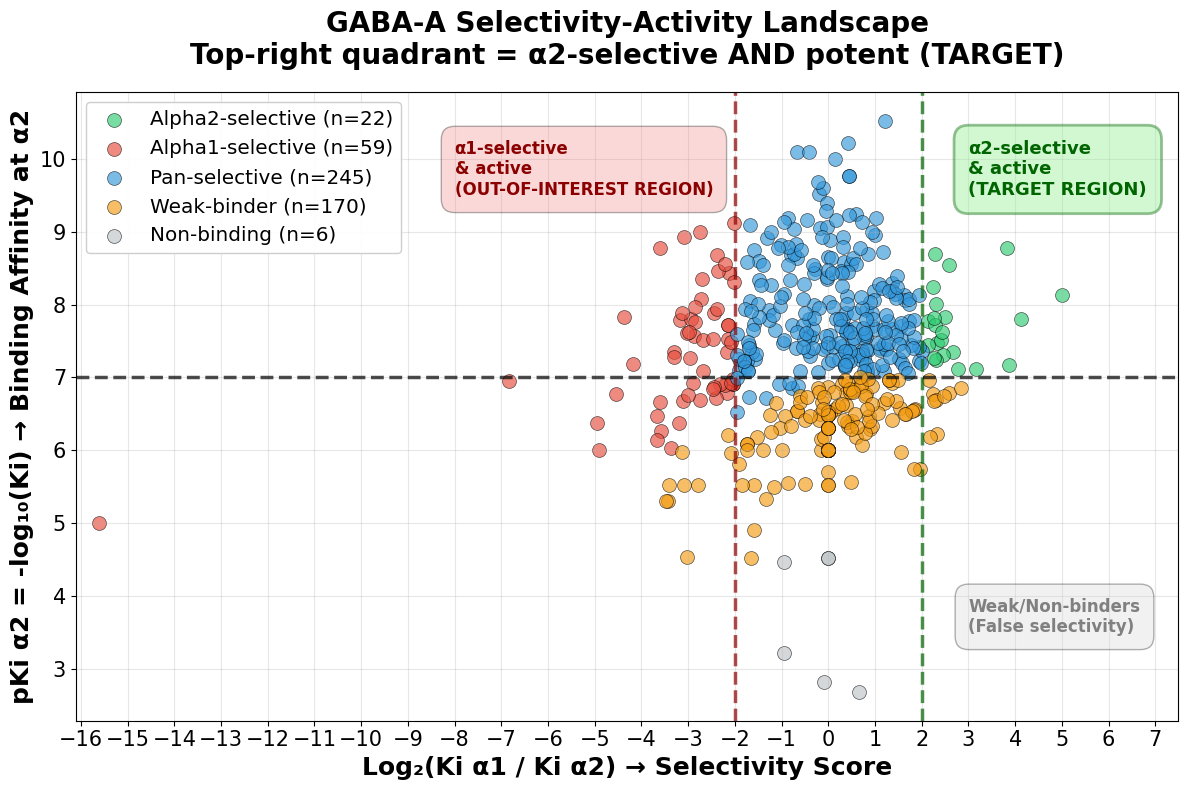

Saved: 02_selectivity_activity_2D.png


In [33]:
print("\nGenerating 2D selectivity-activity plot...\n")

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each label
color_map = {
    'alpha2-selective': '#2ecc71',  # Green
    'alpha1-selective': '#e74c3c',  # Red
    'pan-selective': '#3498db',     # Blue
    'weak-binder': '#f39c12',       # Orange
    'non-binding': '#bdc3c7'        # Light gray
}

# Calculate pKi for better visualization  (pKi = -log10(Ki in M))
merged['pKi_alpha1'] = -np.log10(merged['Ki_alpha1'] * 1e-9)  # Convert nM to M
merged['pKi_alpha2'] = -np.log10(merged['Ki_alpha2'] * 1e-9)  # Convert nM to M

# Plot each category
for label in ['alpha2-selective', 'alpha1-selective', 'pan-selective', 'weak-binder', 'non-binding']:
    subset = merged[merged['refined_label'] == label]
    ax.scatter(subset['log2_ratio'], subset['pKi_alpha2'],
               c=color_map[label], label=f"{label.capitalize()} (n={len(subset)})",
               s=100, alpha=0.65, edgecolors='black', linewidth=0.5)

# Add threshold lines
ax.axvline(2, color='darkgreen', linestyle='--', linewidth=2.5, alpha=0.7)
ax.axvline(-2, color='darkred', linestyle='--', linewidth=2.5, alpha=0.7)
ax.axhline(7, color='black', linestyle='--', linewidth=2.5, alpha=0.7)


# Add region annotations
ax.text(3, 9.5, 'α2-selective\n& active\n(TARGET REGION)',
        fontsize=13, weight='bold', color='darkgreen',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', alpha=0.4, edgecolor='darkgreen', linewidth=2))

ax.text(-8, 9.5, 'α1-selective\n& active\n(OUT-OF-INTEREST REGION)',
        fontsize=12, weight='bold', color='darkred',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightcoral', alpha=0.3))

ax.text(3, 3.5, 'Weak/Non-binders\n(False selectivity)',
        fontsize=12, weight='bold', color='gray',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgray', alpha=0.3))

# Labels
ax.set_xlabel('Log₂(Ki α1 / Ki α2) → Selectivity Score', fontsize=18, weight='bold')
ax.set_ylabel('pKi α2 = -log₁₀(Ki) → Binding Affinity at α2', fontsize=18, weight='bold')
ax.set_title('GABA-A Selectivity-Activity Landscape\nTop-right quadrant = α2-selective AND potent (TARGET)',
             fontsize=20, weight='bold', pad=20)

# Further formatting
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))

ax.legend(fontsize='x-large', loc='upper left', framealpha=0.95, ncol=1)
ax.grid(alpha=0.3, which='both')
ax.set_xlim(merged['log2_ratio'].min() - 0.5, merged['log2_ratio'].max() + 2.5)

plt.tight_layout()
plt.savefig('02_selectivity_activity_2D.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: 02_selectivity_activity_2D.png")

The labeled compounds are not divided perfectly into distinct regions because of the way we defined these labels in section 7. For instance, since a weak binder is defined based on having both pKi less than 6, some compounds are not labeled as weak binders even if they have a pKi for alpha2 less than 6.

## 9. Top α2-Selective Compounds

Display the most promising candidates: compounds with the highest α2 selectivity AND active binding affinity.

These will be used as queries for multi-query ligand-based virtual screening and for building the 3D pharmacophore model.

In [34]:
# Get active α2-selective compounds
alpha2_selective_active = merged[
    merged['refined_label'] == 'alpha2-selective'
].sort_values('log2_ratio', ascending=False).reset_index(drop=True)

print("\n" + "="*70)
print("TOP 10 MOST PROMISING α2-SELECTIVE COMPOUNDS")
print("="*70)
print(f"\nTotal α2-selective active compounds: {len(alpha2_selective_active)}\n")

# Display top 10
print("\nTop 10 most promising α2-selective compounds:\n")
top_10 = alpha2_selective_active.head(10)[[
    'ChEMBL_ID',
    'Ki_alpha1', 'Ki_alpha2', 'pKi_alpha2', 'log2_ratio'
]].copy()

# Format for display
top_10_display = top_10.copy()
top_10_display['Ki_alpha1'] = top_10_display['Ki_alpha1'].apply(lambda x: f"{x:.1f}")
top_10_display['Ki_alpha2'] = top_10_display['Ki_alpha2'].apply(lambda x: f"{x:.1f}")
top_10_display['pKi_alpha2'] = top_10_display['pKi_alpha2'].apply(lambda x: f"{x:.2f}")
top_10_display['log2_ratio'] = top_10_display['log2_ratio'].apply(lambda x: f"{x:.2f}")
top_10_display.columns = ['ChEMBL ID', 'Ki α1 (nM)', 'Ki α2 (nM)', 'pKi α2', 'log₂ Ratio']

print(top_10_display.to_string(index=False))


TOP 10 MOST PROMISING α2-SELECTIVE COMPOUNDS

Total α2-selective active compounds: 22


Top 10 most promising α2-selective compounds:

   ChEMBL ID Ki α1 (nM) Ki α2 (nM) pKi α2 log₂ Ratio
CHEMBL505768      236.0        7.4   8.13       5.00
 CHEMBL50581      280.0       16.0   7.80       4.13
CHEMBL123882     1000.0       68.4   7.16       3.87
 CHEMBL52672       24.0        1.7   8.77       3.82
CHEMBL291335      680.0       76.0   7.12       3.16
CHEMBL179737      520.0       76.0   7.12       2.77
CHEMBL522055      287.0       45.0   7.35       2.67
CHEMBL120838       17.5        2.9   8.54       2.59
CHEMBL361015       85.0       15.0   7.82       2.50
CHEMBL432542      267.0       49.0   7.31       2.45


Chemical structure visualization for quick assessment of chemical diversity in the top hits.

Saved: 03_alpha2_selective_display.png



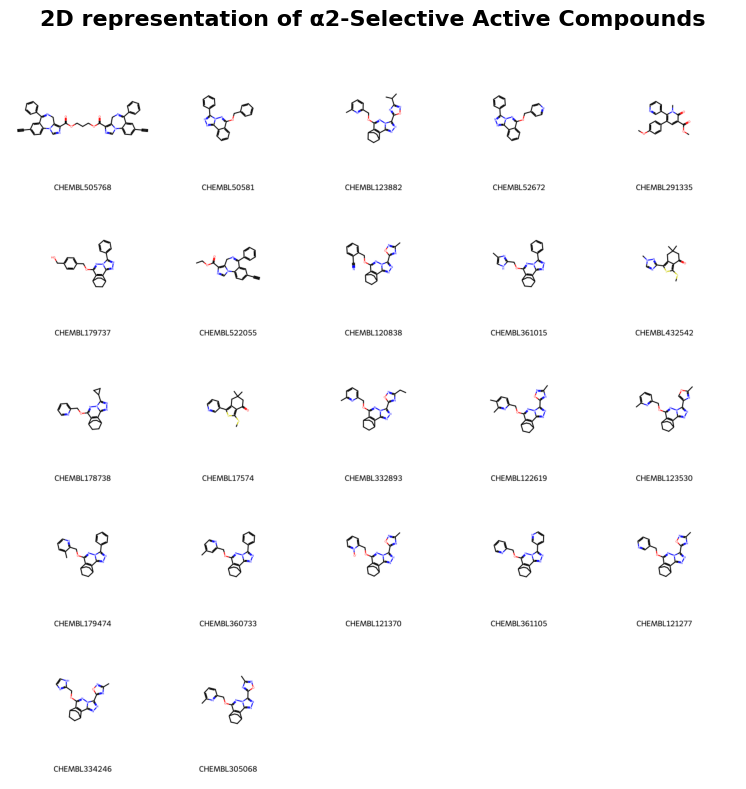

In [35]:
# Convert SMILES to RDKit molecules. Get labels.
a2_selective_mols = [Chem.MolFromSmiles(smi) for smi in alpha2_selective_active['canonical_smiles'].tolist()]
a2_selective_labels = alpha2_selective_active['ChEMBL_ID'].tolist()

# Draw grid
img = Draw.MolsToGridImage(
    a2_selective_mols,
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=a2_selective_labels,
    returnPNG=False
)

# Save and display
img.save('03_alpha2_selective_display.png', dpi=(300, 300))
print("Saved: 03_alpha2_selective_display.png\n")

# Display
plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.axis('off')
plt.title('2D representation of α2-Selective Active Compounds', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

We can see that many of them are actually very similar.

Let's take a look to the top 5

Saved: 04_top5_alpha2_selective_display_with_select_ratio.png



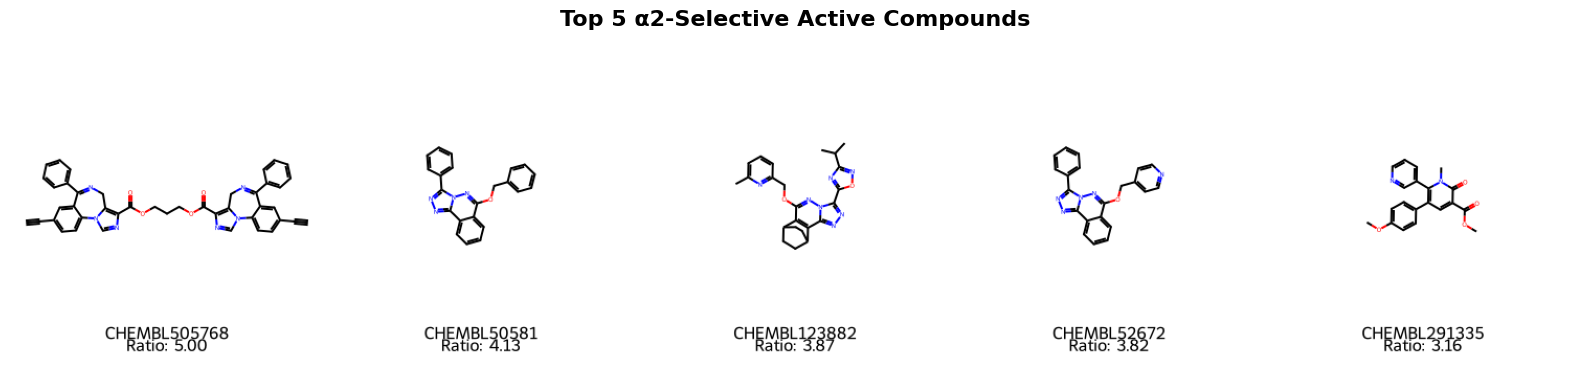

In [36]:
# Convert SMILES to RDKit molecules. Get labels.
top5_a2_selective_mols = [Chem.MolFromSmiles(smi) for smi in alpha2_selective_active.head(5)['canonical_smiles'].tolist()]
# Now the labels include the 'ChEMBL_ID' and the 'log2_selectivity_ratio'
top5_a2_selective_labels = alpha2_selective_active.head(5).apply(lambda row: f"{row['ChEMBL_ID']}\nRatio: {row['log2_ratio']:.2f}", axis=1).tolist()

# Draw grid
img = Draw.MolsToGridImage(
    top5_a2_selective_mols,
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=top5_a2_selective_labels,
    returnPNG=False
)

# Save and display
img.save('04_top5_alpha2_selective_display_with_select_ratio.png', dpi=(300, 300))
print("Saved: 04_top5_alpha2_selective_display_with_select_ratio.png\n")

# Display
plt.figure(figsize=(16, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Top 5 α2-Selective Active Compounds', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

The best hit corresponds to CHEMBL505768, a bivalent compound exhibiting 32-fold α2 selectivity. It looks like two alprazolam-like molecules bound through an ester linker. While its dimeric structure raises questions about monovalent drug-likeness, we retained it for three reasons: (1) it provides spatial information about α2 binding site geometry, (2) excluding outliers prematurely risks discarding genuine potential P.A.M.s, and (3) downstream filters will probably and naturally remove non-drug-like scaffolds.

## 10. Export Training Sets

Two datasets for downstream analysis:
1. **Full dataset:** All compounds with log2 ratios and labels (for documentation/QC)
2. **α2-Selective dataset:** Only active α2-selective compounds (for LBVS/pharmacophore/docking)

In [37]:
len(merged)

502

In [38]:
merged.columns

Index(['canonical_smiles', 'Ki_alpha1', 'Ki_alpha2', 'ChEMBL_ID', 'log2_ratio',
       'refined_label', 'pKi_alpha1', 'pKi_alpha2'],
      dtype='object')

In [39]:
len(alpha2_selective_active)

22

In [40]:
alpha2_selective_active.columns

Index(['canonical_smiles', 'Ki_alpha1', 'Ki_alpha2', 'ChEMBL_ID', 'log2_ratio',
       'refined_label', 'pKi_alpha1', 'pKi_alpha2'],
      dtype='object')

In [41]:
print("\n" + "="*70)
print("EXPORTING DATASETS")
print("="*70)

# Full dataset with all labels
# sort based on the 'refined_label' categorical column
export_full = merged.sort_values('refined_label', ascending=False).reset_index(drop=True)
export_full.to_csv('Training_set_complete.csv', index=False)
print(f"\nExported full dataset: Training_set_complete.csv")
print(f"  Entries: {len(export_full)}")
print(f"  Columns: {', '.join(export_full.columns)}")

# α2-selective active compounds only
alpha2_selective_active.to_csv('Training_set_alpha2_selective.csv', index=False)
print(f"\nExported α2-selective dataset: Training_set_alpha2_selective.csv")
print(f"  Entries: {len(alpha2_selective_active)}")
print(f"  Columns: {', '.join(alpha2_selective_active.columns)}")


EXPORTING DATASETS

Exported full dataset: Training_set_complete.csv
  Entries: 502
  Columns: canonical_smiles, Ki_alpha1, Ki_alpha2, ChEMBL_ID, log2_ratio, refined_label, pKi_alpha1, pKi_alpha2

Exported α2-selective dataset: Training_set_alpha2_selective.csv
  Entries: 22
  Columns: canonical_smiles, Ki_alpha1, Ki_alpha2, ChEMBL_ID, log2_ratio, refined_label, pKi_alpha1, pKi_alpha2


## 11. Cross-Reference with Approved GABA-A Drugs

Identify known therapeutics in the training set to:
1. Validate classification accuracy (α1/α2/pan-selective)
2. Benchmark novel hits against clinical standards
3. Assess chemical diversity vs approved drugs


In [42]:
print("\n" + "="*70)
print("APPROVED DRUGS ANALYSIS")
print("="*70)

# Load approved drugs (note: comma separator, not semicolon)
approved_drugs = pd.read_csv("approved_drugs_for_CHEMBL2093872.csv", sep=';')
print(f"\nTotal approved GABA-A drugs in database: {len(approved_drugs)}")
print(f"Columns: {', '.join(approved_drugs.columns)}")

# Canonicalize approved drug SMILES
print("\nCanonicalizing approved drug SMILES...")
approved_drugs['canonical_smiles'] = approved_drugs['Smiles'].apply(canonicalize_smiles)
approved_drugs_clean = approved_drugs[approved_drugs['canonical_smiles'].notna()].copy()
print(f"Valid approved drugs with canonical SMILES: {len(approved_drugs_clean)}\n")

# Prepare merged data for matching (use only needed columns)
merged_for_match = merged[['canonical_smiles', 'Ki_alpha1', 'Ki_alpha2',
                       'log2_ratio', 'refined_label', 'pKi_alpha1', 'pKi_alpha2']].copy()

# Find matches by canonical SMILES
print("Finding matches by canonical SMILES...")
matches_smiles = merged_for_match.merge(
    approved_drugs_clean[['canonical_smiles', 'Parent Molecule ChEMBL ID',
                     'Parent Molecule Name', 'Parent Molecule Type', 'Max Phase',
                     'First Approval', 'Action Type', 'Mechanism Comment',
                     'Selectivity Comment', 'Binding Site Name', 'Binding Site Comment']],
    on='canonical_smiles',
    how='inner',
    suffixes=('', '_approved')
)

print(f"  Found {len(matches_smiles)} approved drugs in training set by SMILES matching")

# Alternative: Match by ChEMBL ID for additional coverage
print(f"\nAttempting additional match by ChEMBL ID...")
merged_with_chembl = merged[['canonical_smiles', 'ChEMBL_ID', 'Ki_alpha1',
                      'Ki_alpha2', 'log2_ratio', 'refined_label', 'pKi_alpha1', 'pKi_alpha2']].copy()

matches_chembl = merged_with_chembl.merge(
    approved_drugs_clean[['Parent Molecule ChEMBL ID', 'Parent Molecule Name',
                        'Parent Molecule Type', 'Max Phase', 'First Approval',
                        'Action Type', 'Mechanism Comment', 'Selectivity Comment',
                        'Binding Site Name', 'Binding Site Comment']],
    left_on='ChEMBL_ID',
    right_on='Parent Molecule ChEMBL ID',
    how='inner'
)
print(f"  Found {len(matches_chembl)} approved drugs in training set by ChEMBL ID matching")

# Combine and deduplicate
all_matches = pd.concat([matches_smiles, matches_chembl]).drop_duplicates(subset='canonical_smiles')

print(f"\n{'='*70}")
print(f"TOTAL APPROVED DRUGS IN TRAINING SET: {len(all_matches)}")
print(f"{'='*70}")

# Display detailed information with two subsections per molecule
for idx, row in all_matches.iterrows():
    drug_name = row.get('Parent Molecule Name', 'Unknown')

    print(f"\n{'*'*70}")
    print(f"DRUG: {drug_name}")
    print(f"{'*'*70}")

    # SUBSECTION 1: Approved Drug Information
    print(f"\n  APPROVED DRUG INFORMATION:")
    print(f"  {'-'*66}")

    # Max Phase and First Approval (same line)
    max_phase = row.get('Max Phase', 'Unknown')
    first_approval = row.get('First Approval', 'Unknown')
    try:
      first_approval = int(first_approval)
    except:
      if first_approval == 'nan':
        first_approval = 'Unknown'
    print(f"    · Max Clinical Phase: {max_phase}  |  First Approval: {first_approval}")

    # Action Type
    action_type = row.get('Action Type', 'Not specified')
    if pd.notna(action_type) and action_type != '':
        print(f"    · Action Type: {action_type}")

    # Mechanism Comment
    mechanism_comment = row.get('Mechanism Comment', None)
    if pd.notna(mechanism_comment) and mechanism_comment != '':
        print(f"    · Mechanism: {mechanism_comment}")

    # Selectivity Comment
    selectivity_comment = row.get('Selectivity Comment', None)
    if pd.notna(selectivity_comment) and selectivity_comment != '':
        print(f"    · Selectivity: {selectivity_comment}")

    # Binding Site (Name preferred, then Comment)
    binding_site_name = row.get('Binding Site Name', None)
    binding_site_comment = row.get('Binding Site Comment', None)
    if pd.notna(binding_site_name) and binding_site_name != '':
        print(f"    · Binding Site: {binding_site_name}")
    elif pd.notna(binding_site_comment) and binding_site_comment != '':
        print(f"    · Binding Site: {binding_site_comment}")

    # SUBSECTION 2: Training Dataset Information
    print(f"\n  TRAINING DATASET INFORMATION:")
    print(f"  {'─'*66}")

    # ChEMBL ID
    chembl_id = row.get('Parent Molecule ChEMBL ID', 'Unknown')
    print(f"    · ChEMBL ID: {chembl_id}")

    # Classification label
    label = row['refined_label']
    print(f"    · Classification: {label}")

    # Selectivity ratio
    log2 = row['log2_ratio']
    fold_selectivity = 2**log2
    print(f"    · Selectivity: log2 = {log2:.2f} ({fold_selectivity:.1f}-fold)")

    # Ki values
    ki_a1 = row['Ki_alpha1']
    ki_a2 = row['Ki_alpha2']
    print(f"    · Ki α1β3γ2: {ki_a1:.1f} nM")
    print(f"    · Ki α2β3γ2: {ki_a2:.1f} nM")


# Summary statistics
print("\n"*5 + "="*70)
print("APPROVED DRUG CLASSIFICATION SUMMARY")
print("="*70)

summary = all_matches.groupby('refined_label').agg({
    'Parent Molecule Name': 'count',
    'log2_ratio': ['mean', 'std']
}).round(2)
summary.columns = ['Count', 'Mean log2', 'Std log2']
print(summary)

# Export matched drugs
approved_in_training = all_matches[[
    'canonical_smiles', 'Parent Molecule ChEMBL ID', 'Parent Molecule Name',
    'Max Phase', 'First Approval', 'Action Type',
    'Ki_alpha1', 'Ki_alpha2', 'pKi_alpha1', 'pKi_alpha2',
    'log2_ratio', 'refined_label'
]].copy()

approved_in_training.columns = [
    'SMILES', 'ChEMBL_ID', 'Drug_Name', 'Max_Phase', 'First_Approval', 'Action_Type',
    'Ki_alpha1_nM', 'Ki_alpha2_nM', 'pKi_alpha1', 'pKi_alpha2',
    'log2_selectivity_ratio', 'label'
]

approved_in_training = approved_in_training.sort_values('log2_selectivity_ratio', ascending=False)
approved_in_training.to_csv('approved_drugs_in_training_set.csv', index=False)
print(f"\n Saved: approved_drugs_in_training_set.csv")
print(f"  Entries: {len(approved_in_training)}")


APPROVED DRUGS ANALYSIS


FileNotFoundError: [Errno 2] No such file or directory: 'approved_drugs_for_CHEMBL2093872.csv'

All 5 approved drugs classified as pan-selective, except for a weak binder, which makes perfect sense—classic benzodiazepines (diazepam, triazolam, etc.) bind all GABA-A subtypes without much selectivity. Although, diazepam and flunitrazepam have moderate alpha2-selectivity, we want to improve that with this work.

## Summary Statistics

In [ ]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\nDataset composition:")
for label in ['alpha2-selective', 'pan-selective', 'alpha1-selective', 'weak-binder', 'non-binding']:
    count = (merged['refined_label'] == label).sum()
    percentage = (count / len(merged)) * 100
    print(f"  {label:20s}: {count:4d} ({percentage:5.1f}%)")

print(f"\nActive binders (Ki < 100 nM to either subtype): {len(alpha2_selective_active) + len(merged[merged['refined_label']=='pan-selective']) + len(merged[merged['refined_label']=='alpha1-selective'])}")

print(f"\nMatches with approved drugs: {len(all_matches)}")
approved_drug_names_list = [row.get('Parent Molecule Name', 'Unknown') for idx, row in all_matches.iterrows()]
print(f"Names:")
print(approved_drug_names_list)

print(f"\nα2-selective active compounds: {len(alpha2_selective_active)}")

print(f"\nDownstream analysis")
print(f"  - Filter 1: these compounds be used as multi-query LBVS queries.")
print(f"  - Filter 2: survivors from filter 1 will screened with 3D pharmacophore \n \tmodels from alpha2-selective compounds from the training dataset.")
print(f"  - Filter 3: survivors from filter 2, as well as alpha2-selective compounds \n \tfrom the training dataset, will be fine-tested with AutoDock Vina.")

print(f"\nFiles saved:")
print(f"  - 00_Ki_distribution_histograms.png")
print(f"  - 01_selectivity_histogram.png")
print(f"  - 02_selectivity_activity_2D.png")
print(f"  - 03_alpha2_selective_display.png")
print(f"  - 04_top5_alpha2_selective_display_with_select_ratio.png")
print(f"  - Training_set_alpha2_selective.csv")
print(f"  - Training_set_complete.csv")

print(f"\nTraining set construction complete!")